In [1]:
from IPython.display import YouTubeVideo
from functools import partial
YTVideo_formato = partial(YouTubeVideo, width=640, height=400, rel=0, modestbranding=1)

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft
import cv2
from PIL import Image

# Análisis de imágenes en frecuencia


En esta lección veremos:

- Transformada de Fourier bidimensional
- Espectro de imágenes sintéticas y naturales


## Transformada de Fourier bidimensional

La DFT se puede aplicar a funciones multi-dimensionales

En el caso discreto de una señal bidimensional $g[n_1, n_2]$ con índices $n_1 \in [0, N_1-1]$ y $n_2 \in [0, N_2-1]$ tenemos

$$
G[k_1, k_2] = \sum_{n_1=0}^{N_1-1} \sum_{n_2=0}^{N_2-1} g[n_1, n_2] \exp \left ( -j2\pi  \left[\frac{n_1 k_1}{N_1} + \frac{n_2 k_2}{N_2} \right] \right)
$$
y su inversa

$$
g[n_1, n_2] = \frac{1}{N_1 N_2}\sum_{k_1=0}^{N_1-1} \sum_{k_2=0}^{N_2-1} G[k_1, k_2] \exp \left ( j2\pi  \left[\frac{n_1 k_1}{N_1} + \frac{n_2 k_2}{N_2} \right] \right)
$$

Notemos que

$$
\begin{align}
G[k_1, k_2] &= \sum_{n_1=0}^{N_1-1} \left(\sum_{n_2=0}^{N_2-1} g[n_1, n_2] \exp \left (-j2\pi \frac{n_2 k_2}{N_2}\right) \right) \exp \left (-j2\pi \frac{n_1 k_1}{N_1}\right) \\
&= \sum_{n_1=0}^{N_1-1} \hat g_{n_2}[n_1] \exp \left (-j2\pi \frac{n_1 k_1}{N_1}\right),
\end{align}
$$

Es decir que la DFT 2D se puede calcular usando repetidas veces la DFT de una dimensión.

**Ejemplo:** Visualización de la base de Fourier bidimensional

A continuación se muestra la base de Fourier (parte real), son cosenos en dos dimensiones con distintas orientaciones

- La frecuencia cero se ubica en la esquina superior izquierda
- La frecuencia crece de izquierda a derecha y de arriba para abajo

Cuando aplicamos la transformada de Fourier 2D a una imagen estamos separando la imagen en base a estas "texturas" sinusoidales

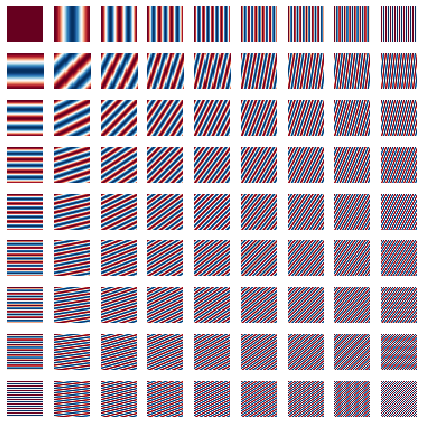

In [3]:
x = np.arange(0, 32, step=1)
X, Y = np.meshgrid(x, x)
fig, ax = plt.subplots(9, 9, figsize=(6, 6), tight_layout=True)

for n in range(9):
    for m in range(9):
        ax[n, m].matshow(np.cos(2.0*np.pi*X*m/len(x) + 2.0*np.pi*Y*n/len(x)), 
                         cmap=plt.cm.RdBu_r, vmin=-1, vmax=1)
        ax[n, m].axis('off')    

## Espectro de una imagen 

Podemos usar la transformada de Fourier 2D para obtener el espectro de amplitud de una imagen

Utilizaremos la siguiente imagen como ejemplo

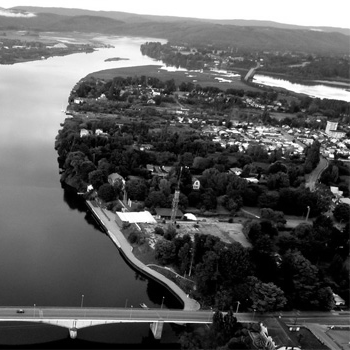

In [4]:
valdivia = cv2.imread('data/valdivia.jpg')
valdivia_bw = cv2.cvtColor(valdivia, cv2.COLOR_BGR2GRAY)[:, 300:]
Image.fromarray(valdivia_bw)

OpenCV tiene implementada la transformada rápida de Fourier en 2 dimensiones

La función `dft` de opencv nos retorna una tensor con dos canales que contienen la parte real y la parte imaginaria de la transformada. Luego podemos utilizar `magnitude` para obtener el espectro

In [5]:
valdivia_bw_float = np.float32(valdivia_bw)
valdivia_dft = cv2.dft(valdivia_bw_float, flags=cv2.DFT_COMPLEX_OUTPUT)
valdivia_magnitude = cv2.magnitude(valdivia_dft[:,:,0], valdivia_dft[:,:,1])

Si lo graficamos directamente veremos:

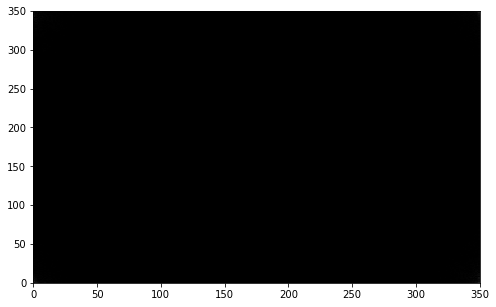

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.pcolor(valdivia_magnitude, cmap=plt.cm.Greys_r);

Que sigue la convención usual, es decir que la frecuencia cero está en la esquina. 

Podemos hacer una visualización más clara dejando el cero al centro con:

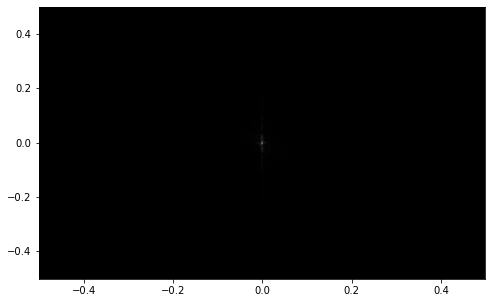

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))
x_axis = scipy.fft.fftshift(scipy.fft.fftfreq(valdivia_magnitude.shape[1]))
y_axis = scipy.fft.fftshift(scipy.fft.fftfreq(valdivia_magnitude.shape[0]))
ax.pcolor(x_axis, y_axis, scipy.fft.fftshift(valdivia_magnitude), cmap=plt.cm.Greys_r);

:::{note}

La energía está muy concentrada en el componente central. Esto es común en imágenes naturales

:::

Para visualizar mejor el espectro de una imagen natural se recomienda usar

$$
\log(|\text{fft2}(I)|+1)
$$

de esta forma el componente central no es tan dominante. En este caso:

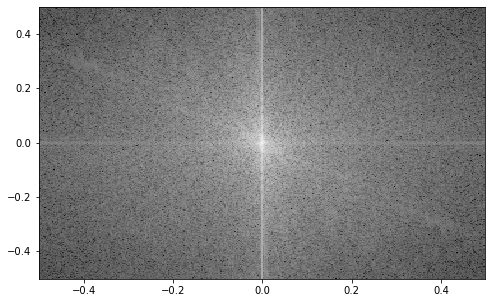

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.pcolor(x_axis, y_axis, 
          scipy.fft.fftshift(np.log(valdivia_magnitude+1)), cmap=plt.cm.Greys_r);

Ahora podemos apreciar otras estructuras en el espectro, pero

:::{attention}

¿A qué corresponden? 

:::

Para entrenarnos en la interpretación del espectro conviene estudiar espectros de imágenes sintéticas

## Espectro de una imagen sintética


**Ejemplo:** Impulsos en frecuencia

Dos impulsos en el espectro corresponde a una sinusoide en el espacio original y viceversa

La posición de los impulsos está asociada a la frecuencia de la sinusoide

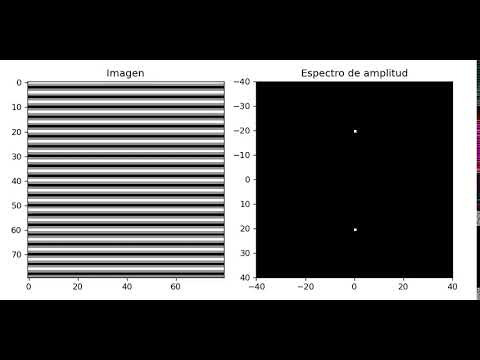

In [9]:
YTVideo_formato('JkYpoMWGbN4')

**Ejemplo:** Espectro de una Linea

Una línea en la imagen es una línea en el espectro (con otra orientación) 

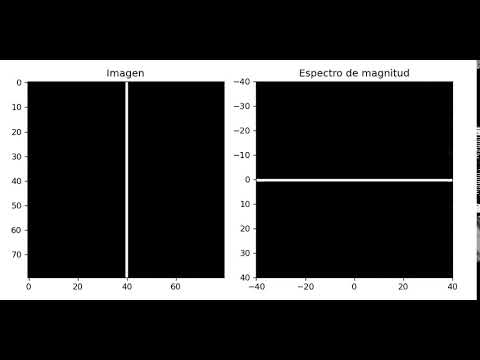

In [10]:
YTVideo_formato('vwey-8_EADg')

:::{attention}

¿Cómo se explica esto?

:::

Consideremos primero el caso donde la rotación es 40 pixeles (linea vertical)

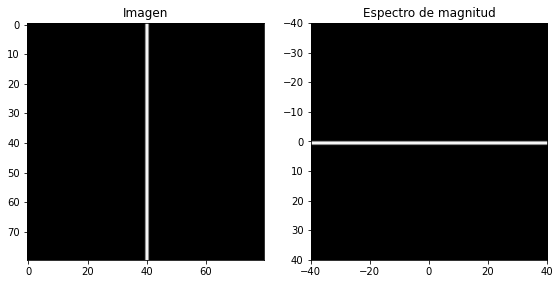

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True); 

def draw_line_spectrum(ax, angle):
    img = np.zeros(shape=(80, 80));     
    for i in range(80):
        img[i, int(i - 2*angle*i/80 + angle)] = 1 

    ax[1].set_title("Espectro de magnitud");  
    ax[0].set_title("Imagen")
    S_img = np.abs(scipy.fft.fft2(img))
    im = ax[1].imshow(scipy.fft.fftshift(S_img), cmap=plt.cm.Greys_r, 
                      extent=[-40, 40, 40, -40])
    im = ax[0].imshow(img, cmap=plt.cm.Greys_r);
    
draw_line_spectrum(ax, 40)

Notemos que en este caso la componente vertical y horizontal pueden independizarse como muestra el sencillo ejemplo a continuación

In [12]:
A = np.array([[0., 0., 1., 0., 0.]])
B = np.array([[1., 1., 1., 1., 1.]])
A*B.T

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

Esto se conoce como una **señal separable**

**Propiedad:** La DFT 2D de una señal separable equivale a la multiplicación de las dos DFT 1D

Una señal es sepable si

$$
g[n_1, n_2] = g_1[n_1] g_2[n_2],
$$

luego aplicando esto en la DFT tenemos

$$
\begin{align}
G[k_1, k_2] &= \sum_{n_1=0}^{N_1-1} \sum_{n_2=0}^{N_2-1} g_1[n_1] g_2[n_2] \exp \left ( -j2\pi  \left[\frac{n_1 k_1}{N_1} + \frac{n_2 k_2}{N_2} \right] \right) \nonumber \\
& = \sum_{n_1=0}^{N_1-1} g_1[n_1] \exp \left ( -j2\pi \frac{n_1 k_1}{N_1} \right)  \sum_{n_2=0}^{N_2-1} g_2[n_2] \exp \left ( -j2\pi\frac{n_2 k_2}{N_2}  \right) \nonumber \\
\end{align}
$$

es decir que se obtiene la multiplicación de cada DFT.

Usemos esta propiedad en el ejemplo anterior.

La primera señal es un impulso en el origen. Su transformada de Fourier es una señal constante

In [13]:
SA = scipy.fft.fftshift(np.abs(scipy.fft.fft(A)))
display(A, SA)

array([[0., 0., 1., 0., 0.]])

array([[1., 1., 1., 1., 1.]])

La segunda señal es una constante

Su transformada de Fourier es un impulso en el origen

(la constante y el impulso en el origen son un par de Fourier)

In [14]:
SB = scipy.fft.fftshift(np.abs(scipy.fft.fft(B)))
display(B, SB)

array([[1., 1., 1., 1., 1.]])

array([[0., 0., 5., 0., 0.]])

**Resultado:** La multiplicación de ambas es una linea rotada en 90 grados con respecto a la original

In [15]:
SA*SB.T

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [5., 5., 5., 5., 5.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

:::{attention}

¿Por qué pareciera repetirse la linea en el espectro cuando la rotación es distinta de 0 pixeles (0 grados), 40 pixeles (90 grados) o 80 pixeles (180 grados)?

:::

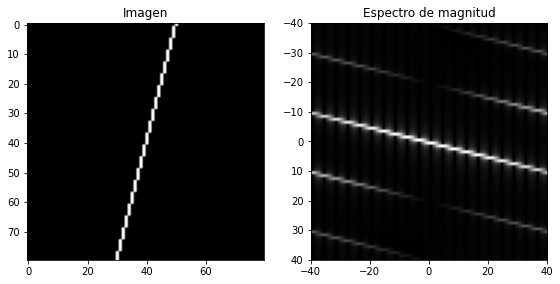

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True);    
draw_line_spectrum(ax, 50)

Este efecto o artefacto obedece a la siguiente propiedad de la DFT

**Propiedad:** La DFT es periodica

En este caso el artefacto que observamos se debe a que en ciertos ángulos los bordes no calzan, tal como muestra la siguiente figura

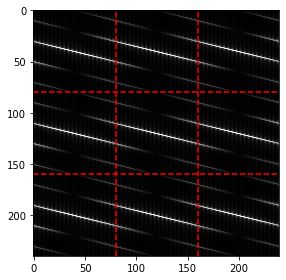

In [17]:
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True); 

img = np.zeros(shape=(80, 80));     
for i in range(80):
    img[i, int(i - 2*50*i/80 + 50)] = 1 

S_img = scipy.fft.fftshift(np.abs(scipy.fft.fft2(img)))
ax.imshow(np.tile(S_img, (3,3)), plt.cm.Greys_r)
ax.axhline(80, c='r', ls='--')
ax.axhline(160, c='r', ls='--')
ax.axvline(80, c='r', ls='--')
ax.axvline(160, c='r', ls='--');

Más adelante veremos como disminuir la influencia de este artefacto usando enventanado

**Ejemplo:** Espectro de un rectangulo

Un rectangulo en la imagen es un sinc en el espectro (y viceverza)

Notemos como mientras más ancho es el rectangulo más angosto es el sinc (y viceversa)

Demostración para una dimensión: https://www.thefouriertransform.com/pairs/box.php

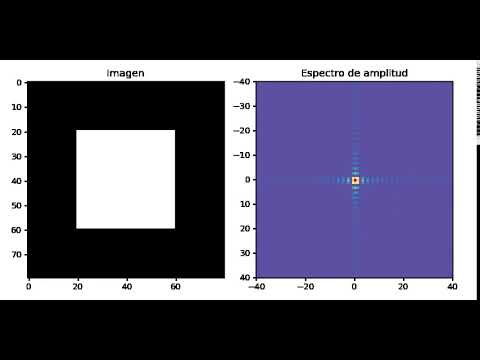

In [18]:
YTVideo_formato('4ctVzvU89lw')

**Ejemplo:** Espectro de una Gaussiana

Una Gaussiana en el espectro es una Gaussiana en el espacio de la imagen

Sin embargo el ancho de la gaussiana en el espectro es inversamente proporcional a la del espacio de la imagen

Demostración para una dimensión: https://www.thefouriertransform.com/pairs/gaussian.php

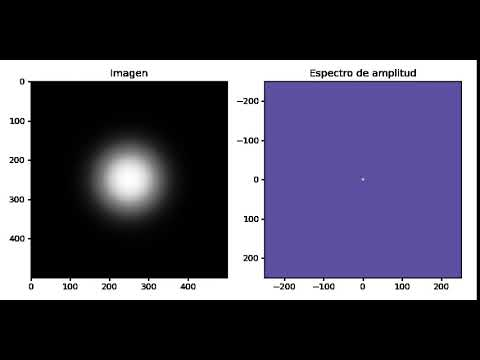

In [19]:
YTVideo_formato('2Sukn_-4Wss')

**Ejemplo:** Espectro de ruido blanco

El espectro de una imagen de ruido blanco es también ruido blanco

El adjetivo "blanco" se refiere a que es un ruido sin color, es decir que aparece de igual forma en todas las frecuencias de la señal

El video a continuación muestre imágenes de ruido blanco gaussiano generado con distitnas semillas y sus correspondientes espectros de magnitud

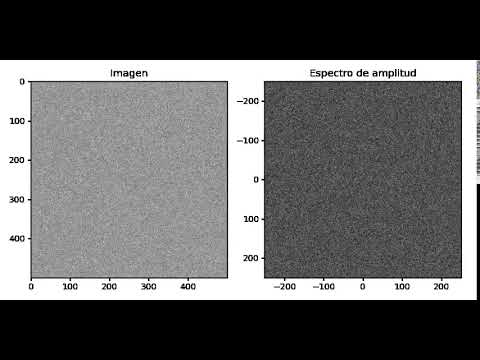

In [20]:
YTVideo_formato("mUTdCJzxLkc")

## Espectro de magnitud y de fase

La DFT en dos dimensiones $G[k_1, k_2]$ es un número complejo y como tal puede escribirse en coordenadas polares como

$$
G[k_1, k_2] = M[k_1, k_2] e^{j \Phi[k_1, k_2]}
$$

donde $j$ es el número imaginario. 

Hasta ahora solo hemos estudiando el valor absoluto $M = | G |$, esto es lo que se conoce como **espectro de magnitud**

>  La **magnitud espectral** guarda información de la amplitud de los componentes de frecuencia en la imagen

Ahora estudiaremos la influencia que tiene $\Phi[k_1, k_2]$, es decir el **espectro de fase** o ángulo 

> La **fase espectral** guarda información de la ubicación de los componentes de frecuencia en la imagen

Consideremos la siguiente imagen de ejemplo

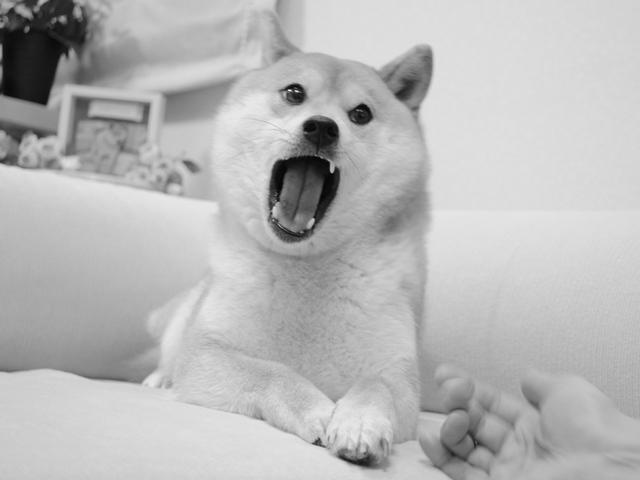

In [21]:
doge = cv2.cvtColor(cv2.imread('data/doge.jpg'), cv2.COLOR_BGR2GRAY)
Image.fromarray(doge)

¿Cómo se ven los espectros de magnitud y fase de esta imagen?

In [22]:
doge_dft = cv2.dft(np.float32(doge), flags=cv2.DFT_COMPLEX_OUTPUT)
doge_magnitude, doge_phase = cv2.cartToPolar(doge_dft[:,:,0], doge_dft[:,:,1])

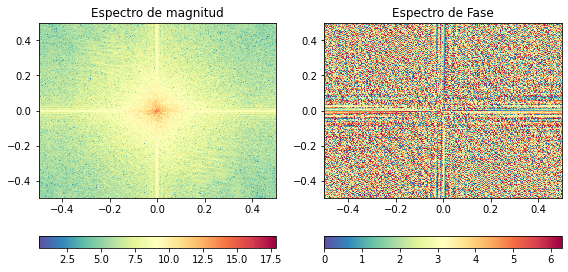

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

x_axis = scipy.fft.fftshift(scipy.fft.fftfreq(doge_dft.shape[1]))
y_axis = scipy.fft.fftshift(scipy.fft.fftfreq(doge_dft.shape[0]))

im = ax[0].pcolor(x_axis, y_axis, scipy.fft.fftshift(np.log(1.+doge_magnitude)), cmap=plt.cm.Spectral_r)
ax[0].set_title('Espectro de magnitud')
fig.colorbar(im, ax=ax[0], orientation='horizontal')
ax[1].set_title('Espectro de Fase')
im = ax[1].pcolor(x_axis, y_axis, scipy.fft.fftshift(doge_phase), cmap=plt.cm.Spectral_r)  
fig.colorbar(im, ax=ax[1], orientation='horizontal');

:::{attention}

¿Podemos reconstruir la imagen usando sólo el espectro de magnitud? ¿O usando sólo el de fase?

:::

Con este sencillo experimento podemos resaltar que es lo que guarda cada espectro

In [24]:
def reconstruct(mag, phase):
    return cv2.dft(cv2.merge([*cv2.polarToCart(mag, phase)]), 
                  flags=cv2.DFT_INVERSE | cv2.DFT_REAL_OUTPUT | cv2.DFT_SCALE)

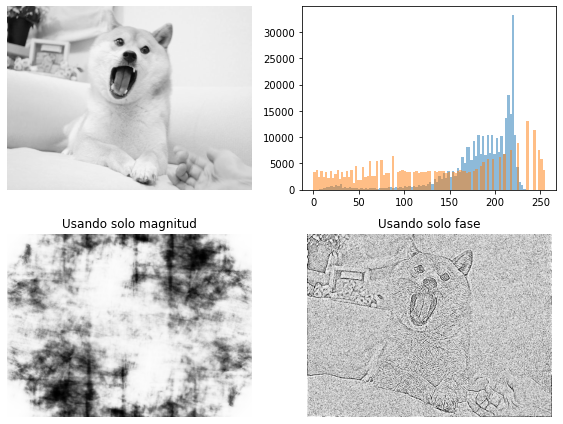

In [25]:
def hist_eq(img, nbins=256):
    image_hist, bins = np.histogram(img.flatten(), nbins, density=True)
    cdf = image_hist.cumsum() 
    cdf = 255 * cdf / cdf[-1] 
    image_eq = np.interp(img.flatten(), bins[:-1], cdf)
    return image_eq.reshape(img.shape).astype('int')
    #return img

fig, ax = plt.subplots(2, 2, figsize=(8, 6), tight_layout=True)
for ax_ in ax.ravel():
    ax_.axis('off')

ax[0, 0].imshow(doge, cmap=plt.cm.Greys_r);
ax[0, 1].hist(doge.ravel(), alpha=0.5, bins=100); 
ax[0, 1].hist(hist_eq(doge.ravel()), alpha=0.5, bins=100);
ax[0, 1].axis('on')
ax[1, 0].set_title('Usando solo magnitud')
ax[1, 0].imshow(hist_eq(reconstruct(doge_magnitude, np.zeros_like(doge_magnitude))), cmap=plt.cm.Greys_r);
ax[1, 1].set_title('Usando solo fase')
ax[1, 1].imshow(hist_eq(reconstruct(np.ones_like(doge_phase), doge_phase)), cmap=plt.cm.Greys_r);

La base de Fourier representa las texturas presentes en la imagen

- El espectro de amplitud nos dice la importancia de cada textura
- El espectro de fase nos dice la dirección de cada textura

Si solo usamos la importancia sin la dirección el resultado es ininteligible

Si solo usamos sólo la dirección podemos entender los contornos pero se pierden la información de intensidad de color (importancia)

:::{attention}

¿Qué pasa si intercambiamos la fase y magnitud de dos imágenes de igual tamaño?

:::

In [26]:
inst = cv2.cvtColor(cv2.imread('data/InsInformatica.jpg'), cv2.COLOR_BGR2GRAY)
inst_dft = cv2.dft(np.float32(inst), flags=cv2.DFT_COMPLEX_OUTPUT)
inst_magnitude, inst_phase = cv2.cartToPolar(inst_dft[:,:,0], inst_dft[:,:,1])

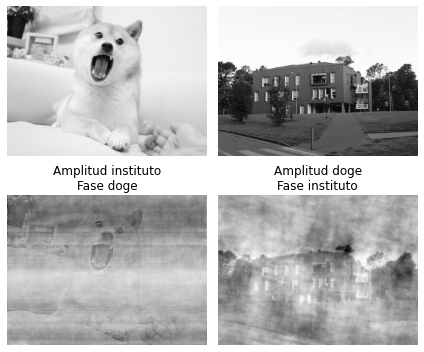

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(6, 5), tight_layout=True)
for ax_ in ax.ravel():
    ax_.axis('off')

ax[0, 0].imshow(doge, cmap=plt.cm.Greys_r);
ax[0, 1].imshow(inst, cmap=plt.cm.Greys_r); 
ax[1, 0].set_title('Amplitud instituto\nFase doge')
ax[1, 0].imshow(reconstruct(inst_magnitude, doge_phase), cmap=plt.cm.Greys_r); 
ax[1, 1].set_title('Amplitud doge\nFase instituto')
ax[1, 1].imshow(reconstruct(doge_magnitude, inst_phase), cmap=plt.cm.Greys_r); 